In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import random
from env1 import StockTradingEnv


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
class Agent:
    def __init__(self, state_dim, balance, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 2  # 0: Buy, 1: Sell
        self.amount_dim = 10  # Discretize amount into 10 bins
        self.memory = deque(maxlen=1000)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.995
        self.is_eval = is_eval
        
        self.model = DQN(state_dim, self.action_dim + self.amount_dim)
        self.target_model = DQN(state_dim, self.action_dim + self.amount_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        
        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}'))
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            action_type = random.randrange(self.action_dim)  # 0 for buy, 1 for sell
            amount_bin = random.randrange(self.amount_dim)  # percentage bin to buy/sell
            amount = (amount_bin + 1) / self.amount_dim  # Convert bin to percentage
            return [action_type, amount]

        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        action_type = torch.argmax(q_values[0, :self.action_dim]).item()
        amount_bin = torch.argmax(q_values[0, self.action_dim:]).item()
        amount = (amount_bin + 1) / self.amount_dim  # Convert bin to percentage

        return [action_type, amount]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = self.model(state)[0]

            with torch.no_grad():
                if done:
                    target[action[0]] = reward
                else:
                    next_q_values = self.model(next_state)
                    next_action = torch.argmax(next_q_values[0, :self.action_dim]).item()
                    next_amount_bin = torch.argmax(next_q_values[0, self.action_dim:]).item()
                    t = self.target_model(next_state)[0]
                    target[action[0]] = reward + self.gamma * t[next_action].item()

            target = target.unsqueeze(0)
            output = self.model(state)
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), name)



In [4]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_STEPS = 10000
INITIAL_ACCOUNT_BALANCE = 10000


In [5]:

df = pd.read_csv('A.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = Agent(state_dim=state_dim, balance=INITIAL_ACCOUNT_BALANCE)


Time: 0 episode: 1/10 score: 10000
Time: 100 episode: 1/10 score: 10063.87081101726
Time: 200 episode: 1/10 score: 10356.802093442468
Time: 300 episode: 1/10 score: 10616.747857645405
Time: 400 episode: 1/10 score: 10963.804582150147
Time: 500 episode: 1/10 score: 8337.105168181626
Time: 600 episode: 1/10 score: 8720.110159059052
Time: 700 episode: 1/10 score: 10878.470434883375
Time: 800 episode: 1/10 score: 10746.023247660776
Time: 900 episode: 1/10 score: 13506.767396845215
Time: 1000 episode: 1/10 score: 15454.991284126321
Time: 1100 episode: 1/10 score: 16458.39302632427
Time: 1200 episode: 1/10 score: 14151.677659461608
Time: 1300 episode: 1/10 score: 16315.484308251287
Time: 1400 episode: 1/10 score: 17624.752960838206
Time: 1500 episode: 1/10 score: 17971.171704388988
Time: 1600 episode: 1/10 score: 17572.813074591817
Time: 1700 episode: 1/10 score: 18380.51627744303
Time: 1800 episode: 1/10 score: 18331.94584170217
Time: 1900 episode: 1/10 score: 18351.79952869057
Time: 2000 e

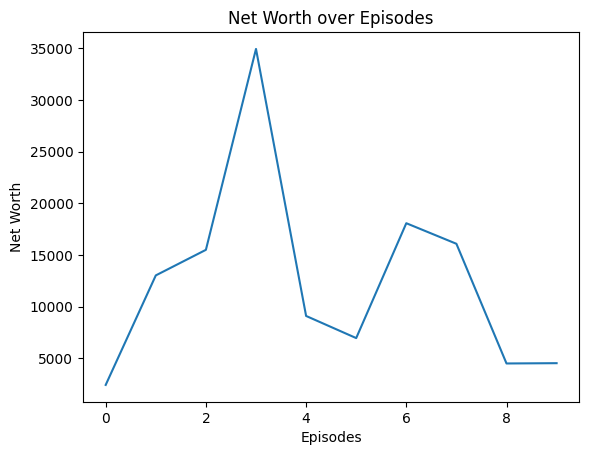

In [6]:
episodes = 10
net_worths = []
best_net_worth = -1 

for e in range(episodes):
    state, _ = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    for time in range(MAX_STEPS):
        if time % 100 == 0:
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            agent.update_target_model()
            print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
            break
        agent.replay()
    net_worths.append(env.net_worth)
    if env.net_worth > best_net_worth:
        best_net_worth = env.net_worth
        agent.save(f"best_model_ddqn.pth")
    if (e + 1) % 10 == 0:
        agent.save(f"ddqn_final_{e+1}.pth")

    print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')


print(net_worths)
# Plotting the net worth over episodes
plt.plot(range(episodes), net_worths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()


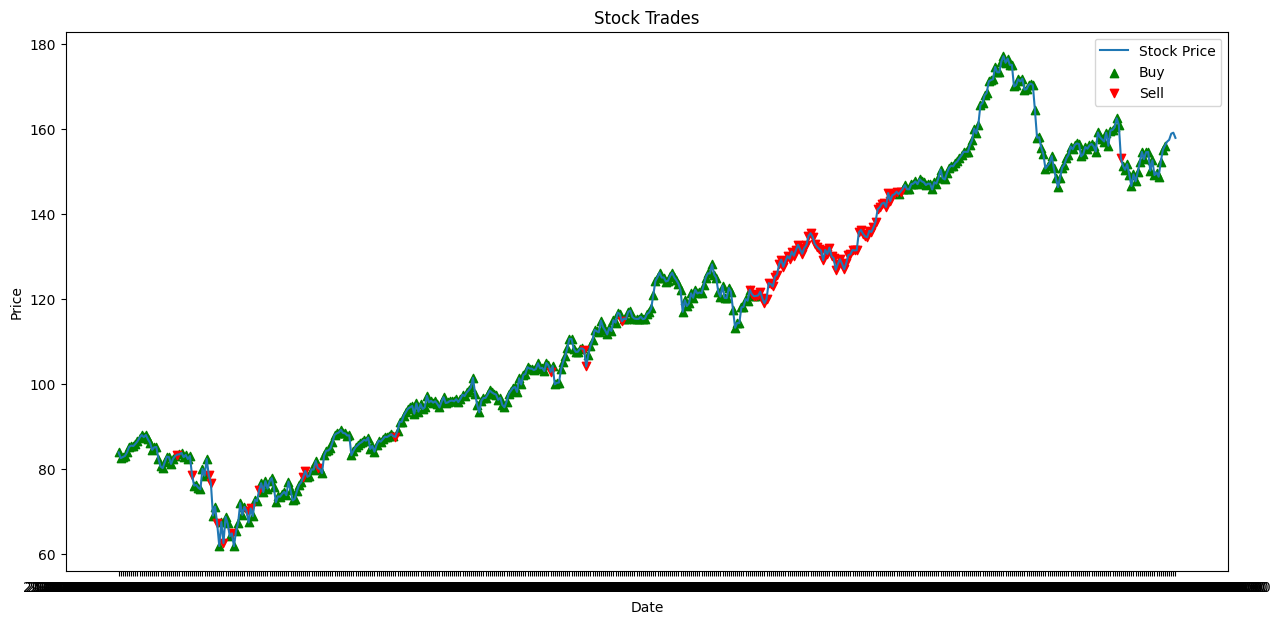

[10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10019.599469736262,
 10012.49379865655,
 10053.27409480938,
 10079.813196479421,
 10074.219170685932,
 10043.756925495318,
 10084.646902860934,
 10148.760038668886,
 10173.780421848718,
 10125.673400538162,
 10196.266828570177,
 10194.969565449395,
 10147.046908391112,
 10181.30

In [11]:
def evaluate(agent, env, start_date, end_date):
    df = env.df
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    df = df.loc[mask]
    env.df = df.reset_index(drop=True)
    
    state, _ = env.reset()
    state = state.flatten()
    net_worths = []
    trades = []

    agent.epsilon = 0.0  # Disable exploration during evaluation
    for current_step in range(len(env.df)):
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = next_state.flatten()
        trades.append((env.current_step, action[0], action[1]))  # Log the trade action
        state = next_state
        net_worths.append(env.net_worth)

    plt.figure(figsize=(15, 7))
    plt.plot(env.df['Date'], env.df['Close'], label='Stock Price')
    buy_trades = [trade for trade in trades if trade[1] == 0]
    sell_trades = [trade for trade in trades if trade[1] == 1]
    plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                marker='^', color='g', label='Buy', alpha=1)
    plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                marker='v', color='r', label='Sell', alpha=1)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Trades')
    plt.legend()
    plt.show()

    return net_worths

agent.load("model_ddqn_10.pth")
evaluate(agent, env, start_date='2020-01-01', end_date='2022-01-01')
